# Final Project
# Topic 4: High-dynamic range imaging. (Debevec-Malik method)

All contents written by Minqi Xu.

email: m259xu@uwaterloo.ca

The reason I choose this topic as the final profect topic is that I am interested in photography, and I notice that on recently device, there is a function called HDR. I have briefly inquired about the principle, and it seems to be to take multiple photos with different exposures and then perform algorithmic synthesis. So when I saw this topic, I immediately get interested in it. Also, I saw that the difficulty of this topic is a single plus, which is suitable for me to complete the project alone, so I chose it without hesitation.

The goal of this project is to implement the Debevec-Malik method.

Note that cv2 is imported, and it is not installed with the default anaconda package. The way to install it is type "pip install opencv-python" in terminal.

numpy is imported since we are going to use np.ndarray to store images.

matplotlib.pyplot is imported to display plots.

matplotlib.image is imported to load and display images.

random is imported to randomly select sample pixel.

cv2(openCV) is imported since we need to apply a non-linear bilateral filter during tone mapping. Also the normalize is used.

nupy.linalg is imported to calculate the inverse of matrix.

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as image
import random
from numpy import linalg as la
import cv2

We need to read the image and exposure time first

In [2]:
def get_img_info():
    # channel: the channel that we want, range = {0,1,2}
    img_list = []
    img_list.append(image.imread("image/blimp1.jpg"))
    img_list.append(image.imread("image/blimp2.jpg"))
    img_list.append(image.imread("image/blimp3.jpg"))
    
    exposure_times = np.array([1/2048, 1/1024, 1/512], dtype=float)
    return (img_list, exposure_times)

In [3]:
def create_sample(img_list):
    # randomly sample pixel intensity
    # img_list: list[np.ndarray], a list contains image of single channel
    
    img_num = len(img_list)
    z_min = 0
    z_max = 255
    i_num = z_max - z_min + 1
    i_value = np.zeros((i_num, img_num), dtype=np.uint8)
    
    temp_img = img_list[img_num//2]
    
    for i in range(z_min, z_max+1):
        x,y = np.where(temp_img == i)
        if len(x) > 0:
            rand_num = random.randrange(len(x))
            for j in range(img_num):
                i_value[i][j] = img_list[j][x[rand_num]][y[rand_num]]
    return i_value

Following there step, we move to stage 1: Estimate the radiometric response function from the aligned images.

In [4]:
def weight_func(value):
    z_min = 0.0
    z_max = 255.0
    if value <= (z_min + z_max) / 2:
        return value - z_min
    return z_max - value

def recover_response_curve(lambdaa, log_e, sample):
    # lambdaa is the smoothing variable
    # log_e: np.ndarray, is the log of the exposure times
    # sample: np.ndarray, Single channel input of values
    
    i_range = 255  # intensity_range
    sample_num = sample.shape[0]
    image_num = len(log_e)
    
    A = np.zeros((image_num * sample_num + i_range, sample_num + i_range + 1), dtype=float)
    B = np.zeros((A.shape[0], 1), dtype=float)
    
    # add the data-fitting:
    k = 0
    for i in range(sample_num):
        for j in range(image_num):
            z = sample[i][j]
            w = weight_func(z)
            A[k][z] = w
            A[k][i_range+1+i] = -w
            B[k][0] = w * log_e[j]
            k = k+1
    
    # add the smoothing:
    for z in range(1, 255):
        w = weight_func(z)
        A[k][z-1] = lambdaa * w
        A[k][z] = -2 * lambdaa * w
        A[k][z+1] = lambdaa * w
        k = k + 1
    
    # set middle to 0
    A[k][255//2] = 1
    
    
    A_inv = np.linalg.pinv(A)
    temp = np.matmul(A_inv, B)
    
    g = temp[0: i_range+1]
    return g[:,0]
    
    
    

After the first stage, we are moving to the second stage, which is estimate a radiance map by selecting or blending pixels from different exposures. We need to merge the input images into a composite radiance map.

In [5]:
def getRadianceMap(img_list, log_e, response):
    # img_list: list[np.ndarray], a list contains image of single channel
    # log_e: np.ndarray, log exposure times
    # response: np.ndarray, response curve
    
    img_shape = img_list[0].shape
    rad = np.zeros(img_shape, dtype=float)
    
    img_num = len(img_list)
    
    for i in range(img_shape[0]):
        for j in range(img_shape[1]):
            g = np.array([response[img_list[k][i][j]] for k in range(img_num)])
            w = np.array([(img_list[z][i][j] if img_list[z][i][j] <= (255.0/2.0) else (255-img_list[z][i][j])) \
                                                                          for z in range(img_num)])
            tot = np.sum(w)
            if tot>0:
                rad[i][j] = np.sum(w * (g - log_e) / tot)
            else:
                rad[i][j] = g[img_num // 2] - log_e[img_num // 2]
                #rad[i][j] = np.sum(w * (g - log_e))
    
    return rad

After calculate the radiance map, we are now moving to the third stage, which is tone map the resulting high dynamic range (HDR) iamge back into a displayable gamut. Following, we are going to use the Durand's method of local tone mapping using a bilateral filter.

In [6]:
def toneMap(img, gamma=0.6, sigma_space=4, sigma_color=4):
    # img: np.ndarray, image needed to be correct
    
    
    # get Luminance of img
    img_intensity = np.average(img, axis=2, weights=[0.2126, 0.7152, 0.0722]) # this data comes from internet
    
    # compute the chrominance channels
    R = img[:,:,0]/img_intensity
    G = img[:,:,1]/img_intensity
    B = img[:,:,2]/img_intensity
    
    # compute the log of the intensity
    L = np.log2(img_intensity)
    
    # apply bilateral filter
    L = np.float32(L)
    blur = cv2.bilateralFilter(L, d=3, sigmaColor=sigma_color, sigmaSpace=sigma_space)
    
    # compute the detail layer
    detail_layer = L - blur
    
    # apply offset and scale to base
    offset = np.max(blur)
    scale = 6 / (np.max(blur) - np.min(blur))
    base = (blur - offset) * scale
    
    # reconstruct log intensity
    log_i_reconstruct = np.zeros_like(blur)
    log_i_reconstruct.fill(2)
    log_i_reconstruct = np.power(log_i_reconstruct, (blur + detail_layer))
    
    # reconstruct colors
    R_re = log_i_reconstruct * R
    G_re = log_i_reconstruct * G
    B_re = log_i_reconstruct * B
    
    newimg = img.copy()
    newimg[:,:,0]=R_re
    newimg[:,:,1]=G_re
    newimg[:,:,2]=B_re
    
    newimg = newimg.astype('float32')/255
    
    # apply gamma correction
    newimg = np.power(newimg, 1/gamma)
    
    plt.figure(figsize = (12, 8))
    plt.subplot(231)
    plt.title('image of base')
    plt.imshow(blur)
    plt.subplot(232)
    plt.title('image of detail layer')
    plt.imshow(detail_layer)
    plt.subplot(233)
    plt.title('image of log\(intensity\) reconstruction')
    plt.imshow(log_i_reconstruct)
    plt.subplot(234)
    plt.title('image after tone mapping')
    plt.imshow(newimg)
    plt.subplot(235)
    plt.title('intensity')
    plt.imshow(img_intensity)
    plt.show()
    
    
    return newimg

In [7]:
def getHDR(img_list, log_e, lambdaa=100):
    # img_list: list[np.ndarray], list of images
    # log_e: np.ndarray: log of exposure times for images
    
    image_shape = img_list[0].shape
    channel_num = img_list[0].shape[2]
    hdr_img = np.zeros(image_shape, dtype=float)
    
    for i in range(channel_num):
        # split the channels
        single_channel = [img[:,:,i] for img in img_list]
        
        # get the sample intensity
        sample = create_sample(single_channel)
        
        # calculate response curve
        response_curve = recover_response_curve(lambdaa, log_e, sample)
        
        # create radiance map
        rad_map = getRadianceMap(single_channel, log_e, response_curve)
        
        # get the hdr img, and normalize it to (0,255)
        hdr_img[:,:,i] = cv2.normalize(rad_map, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
        
    hdr_img = np.float32(hdr_img)
    # applying tone mapping
    map_img = toneMap(hdr_img)
    
    return map_img

After this, we obtained a raw HDR image, we still need to Adjust the intensity of each channel of this image. We can choose our target intensity as the same as middle image.

In [8]:
def intensityCorrection(rawHDR, target):
    # rawHDR: np.ndarray, raw HDR image that need to be correct
    # target: np.ndarray, the target intensity that tempHDR need to be corrected
    
    finalHDR = np.zeros_like(rawHDR)
    for i in range(rawHDR.shape[2]):
        rawVal = np.average(rawHDR[:,:,i])
        targetVal = np.average(target[:,:,i])
        finalHDR[:,:,i] = rawHDR[:,:,i] * targetVal / rawVal
    
    # normalize the finalHDR
    finalHDR = cv2.normalize(finalHDR, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
    
    return finalHDR.astype(np.uint8)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


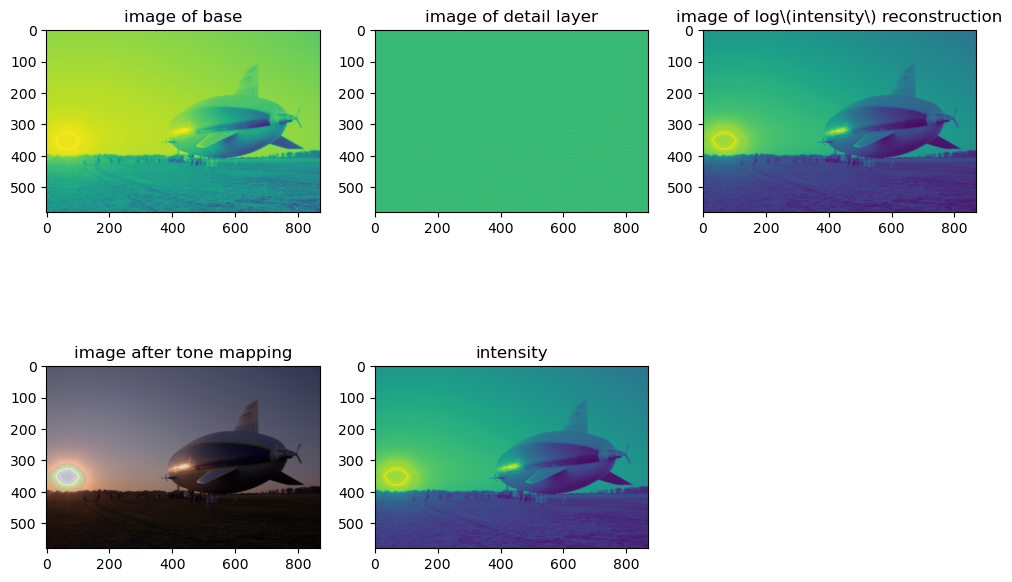

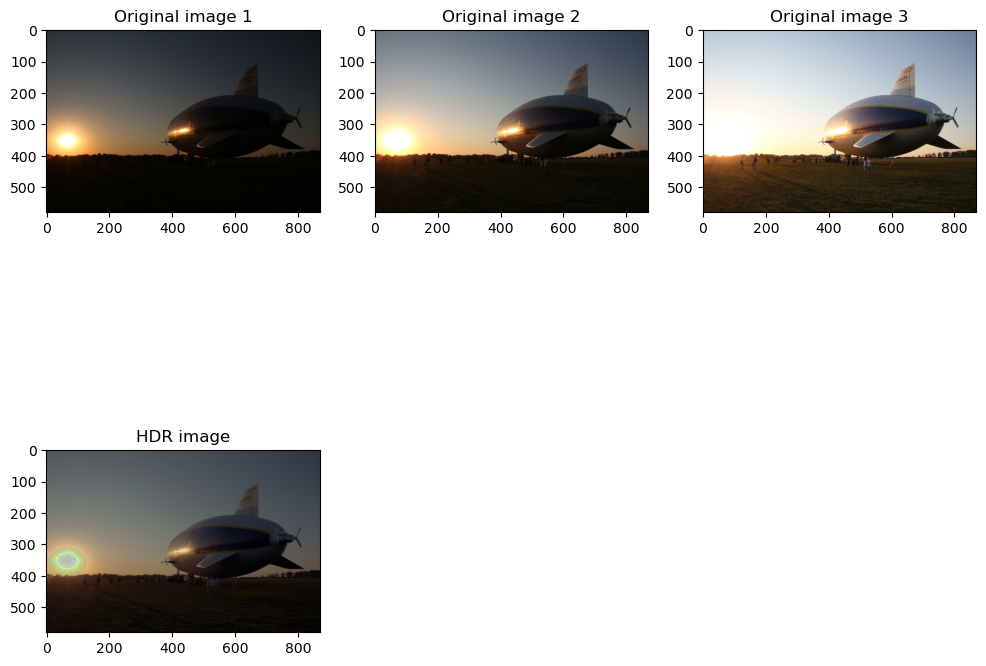

In [9]:
img_list, exposure_time = get_img_info()
log_e = np.log2(exposure_time)

HDR_img = getHDR(img_list, log_e)

# need to correct the intensity
target = img_list[len(img_list)//2]
finalHDR = intensityCorrection(HDR_img, target)

plt.figure(figsize = (12, 10))
plt.subplot(231)
plt.title('Original image 1')
plt.imshow(img_list[0])
plt.subplot(232)
plt.title('Original image 2')
plt.imshow(img_list[1])
plt.subplot(233)
plt.title('Original image 3')
plt.imshow(img_list[2])
plt.subplot(234)
plt.title('HDR image')
plt.imshow(finalHDR)
plt.show()

In the previous cell, the last image is the HDR we obtained, although it is not that good, but compared to the second original image, the ground is slightly lighter, and the sun is darker.

Here are two more examples from https://www.easyhdr.com/examples/

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


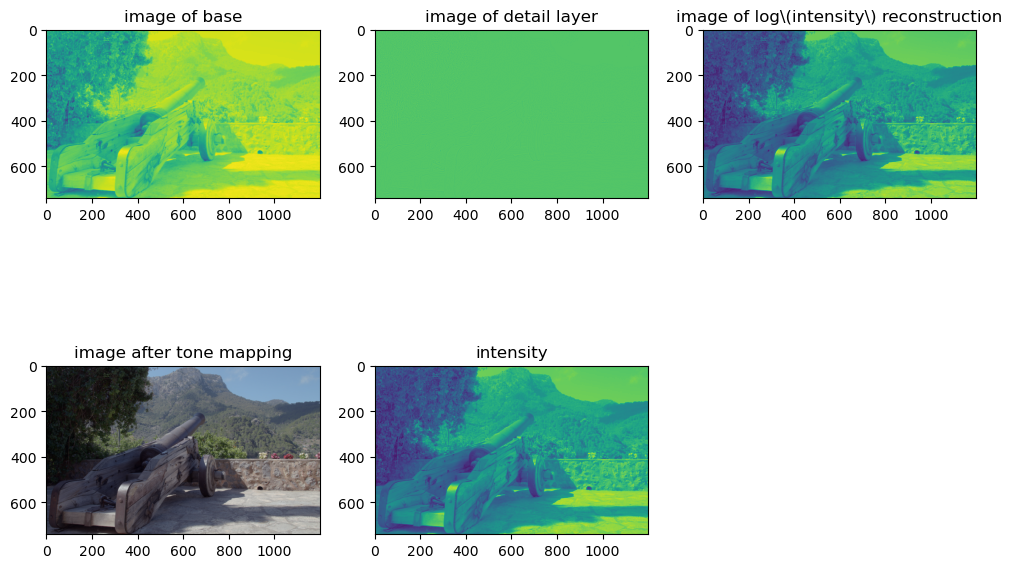

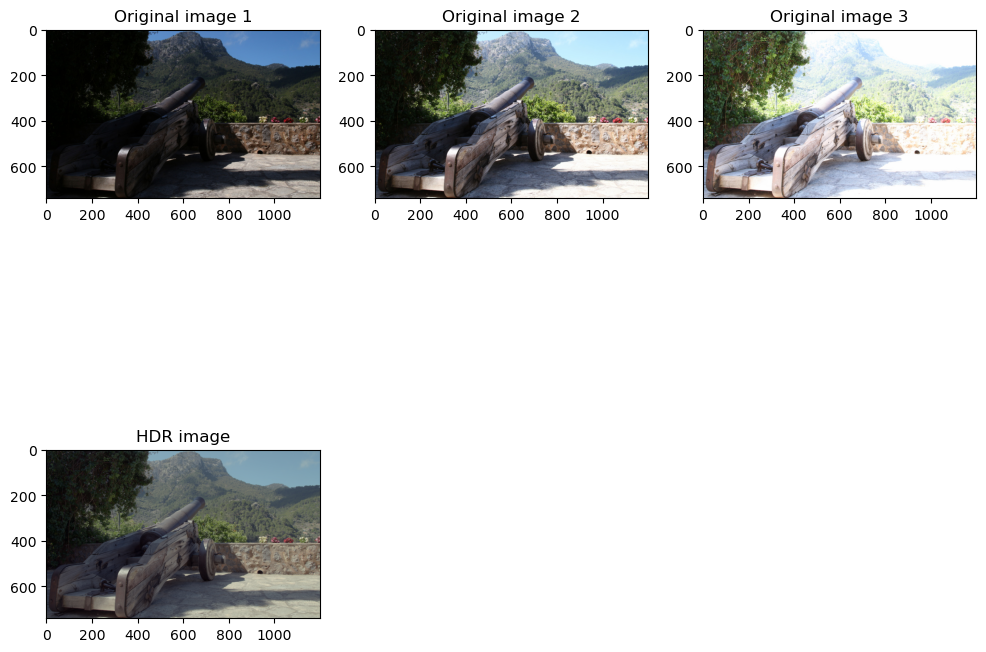

In [10]:
img_list = []
img_list.append(image.imread("image/cannon1.jpg"))
img_list.append(image.imread("image/cannon2.jpg"))
img_list.append(image.imread("image/cannon3.jpg"))
    
exposure_times = np.array([1/2048, 1/1024, 1/512], dtype=float)
log_e = np.log2(exposure_times)

HDR_img = getHDR(img_list, log_e)

# need to correct the intensity
target = img_list[len(img_list)//2]
finalHDR = intensityCorrection(HDR_img, target)

plt.figure(figsize = (12, 10))
plt.subplot(231)
plt.title('Original image 1')
plt.imshow(img_list[0])
plt.subplot(232)
plt.title('Original image 2')
plt.imshow(img_list[1])
plt.subplot(233)
plt.title('Original image 3')
plt.imshow(img_list[2])
plt.subplot(234)
plt.title('HDR image')
plt.imshow(finalHDR)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


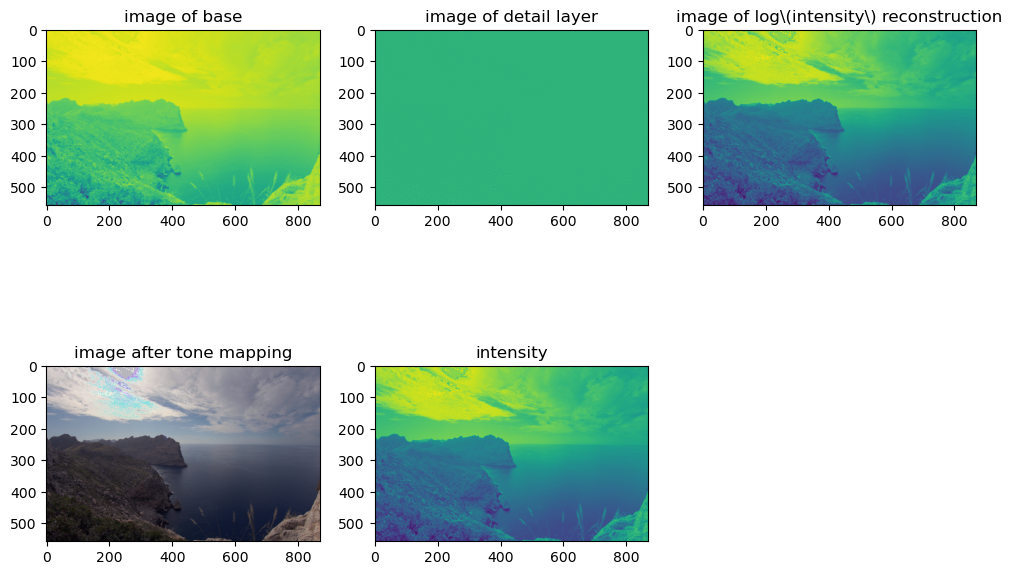

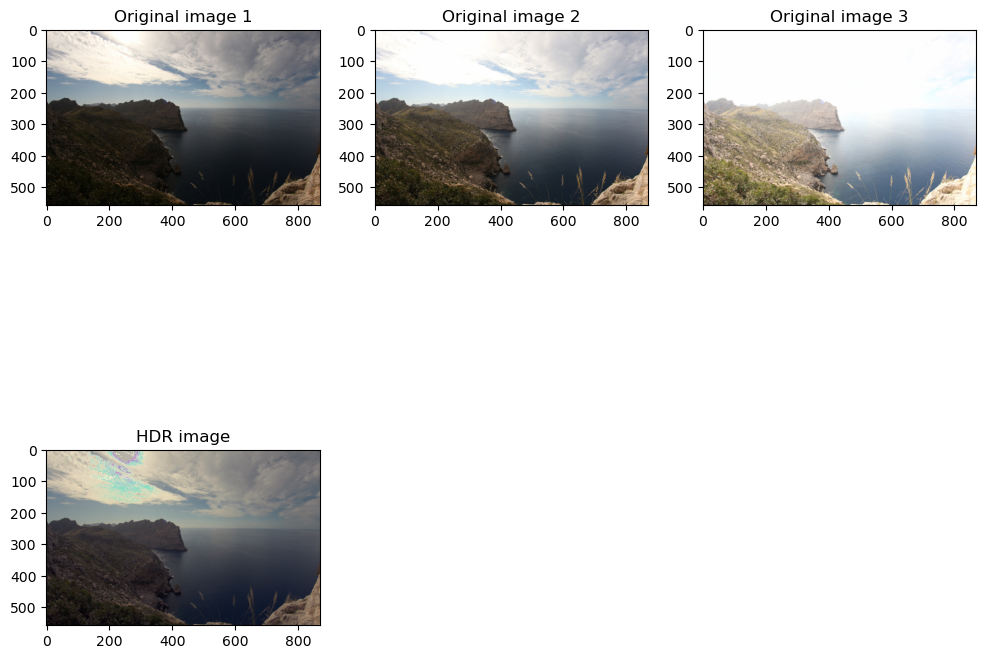

In [11]:
img_list = []
img_list.append(image.imread("image/cap-de-formentor1.jpg"))
img_list.append(image.imread("image/cap-de-formentor2.jpg"))
img_list.append(image.imread("image/cap-de-formentor3.jpg"))
    
exposure_times = np.array([1/2048, 1/1024, 1/512], dtype=float)
log_e = np.log2(exposure_times)

HDR_img = getHDR(img_list, log_e)

# need to correct the intensity
target = img_list[len(img_list)//2]
finalHDR = intensityCorrection(HDR_img, target)

plt.figure(figsize = (12, 10))
plt.subplot(231)
plt.title('Original image 1')
plt.imshow(img_list[0])
plt.subplot(232)
plt.title('Original image 2')
plt.imshow(img_list[1])
plt.subplot(233)
plt.title('Original image 3')
plt.imshow(img_list[2])
plt.subplot(234)
plt.title('HDR image')
plt.imshow(finalHDR)
plt.show()

In these examples, especially the second one where there is a cannon. It is obviously that the HDR image is gathering the information from three original images well without over- or under-exposure.